Demonstates how a number of different machine learning models perform on the cleaned data. Models tested include simple linear regression, lasso regression, a decision tree regressor, and a random forest regressor. Only the best performing model (the random forest) is used in the `ATP_script` notebook.

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [ ]:
cleaned_df = pd.read_csv("cleaned_atp_data.csv", index_col=0)

# Split into matches to fit and matches to predict
matches_to_fit = cleaned_df[pd.isnull(cleaned_df['prizepicks_line'])]
matches_to_predict = cleaned_df[pd.notna(cleaned_df['prizepicks_line'])]

,name,opp_name,tourney_date,grand_slam,best_of,surface,age,opp_age,seed_diff,rank_points_diff,...,avg_svpt,avg_FirstIn,avg_FirstWon,avg_SecondWon,avg_SvGms,avg_bpSaved,avg_bpFaced,h2h_fantasy_pts,fantasy_pts,prizepicks_line
100202,Rafael Nadal,NaN,20220806,1,5,Grass,35.533607,26.185368,0.0,0.0,...,76.801379,52.428966,37.713103,13.824828,12.515862,3.528276,5.364138,20.030458,NaN,23.0
100203,Novak Djokovic,NaN,20220806,1,5,Grass,35.133607,26.185368,0.0,0.0,...,80.486172,51.979622,38.285298,15.723435,12.988355,3.583697,5.462882,20.030458,NaN,11.0
100204,Nick Kyrgios,NaN,20220806,1,5,Grass,27.333607,26.185368,0.0,0.0,...,84.910526,55.942105,43.963158,15.547368,13.826316,2.994737,4.384211,20.030458,NaN,16.0


## Preprocess Data

In [ ]:
# Save numeric variables (and surface)
num_vars = [
    'grand_slam', 'best_of', 'surface', # Tourney vars
    'age', 'opp_age', 'seed_diff', 'rank_points_diff', # Player vars
    'avg_fantasy_pts', 'avg_ace', 'avg_df', 'avg_svpt', 'avg_FirstIn', # Stat avgs
    'avg_FirstWon', 'avg_SecondWon', 'avg_SvGms', 'avg_bpSaved', 'avg_bpFaced', # Stat avgs
    'h2h_fantasy_pts', # H2H avgs
    'fantasy_pts'] # Response var
matches_to_fit = matches_to_fit[num_vars]

# Create dummy variables for surface
model_df = pd.get_dummies(data=matches_to_fit, columns=['surface'])

## Train-Test Split

In [ ]:
# Separate predictor and response variables
X = model_df.drop(['fantasy_pts'], axis = 1)
y = model_df['fantasy_pts']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Modeling

### Simple Linear Regression

In [ ]:
# Fit and predict a linear model
lm = LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)

# Print train and test statistics
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.20609800324935035
Train MSE: 56.56426974602789

Test R-Squared: 0.1892984285471253
Test MSE: 57.425641407300766


### Lasso Regression

In [ ]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=1, max_iter=10000)

# Fit these models and record accuracy
model.fit(X_train, y_train)

# Run lasso on the best alpha value
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)
y_train_pred = lasso_best.predict(X_train)
y_pred = lasso_best.predict(X_test)

# Print train and test statistics
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: -0.4141010114171215
Train MSE: 64.72148439908413

Test R-Squared: -0.4219636812218521
Test MSE: 65.24619110379632


### Decision Tree Regressor

In [ ]:
# Grid search for best parameters
parameters = {'max_depth': [2,4,6,8,10,12],
             'min_samples_split': [2,3,4],
             'min_samples_leaf': [1,2]}
tree = DecisionTreeRegressor()
gscv = GridSearchCV(estimator=tree,param_grid=parameters)
gscv.fit(X_train, y_train)

# Fit model with the best parameters
model = gscv.best_estimator_
model.fit(X_train, y_train)

# Print train and test statistics
y_train_pred = model.predict(X_train)
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
y_pred = model.predict(X_test)
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.7098193498458314
Train MSE: 28.74696028429339

Test R-Squared: 0.6334699360693778
Test MSE: 36.48207274253578


### Random Forest Regressor

In [ ]:
# Fit a random forest and predict
rfor = RandomForestRegressor(max_depth=19, max_features=1.0)
rfor.fit(X_train, y_train)


# Print train and test statistics
y_train_pred = rfor.predict(X_train)
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
y_pred = rfor.predict(X_test)
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.9041648599350857
Train MSE: 10.0711620159379

Test R-Squared: 0.7141449088898958
Test MSE: 27.92542881010073


## Model Selection and Prediction

It is clear that the random forest regressor performs the best, so we will select this model and perform additional analysis.

*Mean-absolute-error of 3.86 fantasy points is a very satisfying result, as the standard deviation of results is 11.32 points. Decent performance can be achieved by selecting a set number of points for the predicted winner and a set number of points for the predicted loser, but this model performs better than that. MAE is probably more relevant than MSE because we do not care about penalizing based on how inaccurate predictions are; we are just predicting if the value does or does not exceed the over/under line set by PrizePicks.

Test R-Squared: 0.7141449088898958
Test MSE: 27.92542881010073
Test MAE: 3.9066139607819106


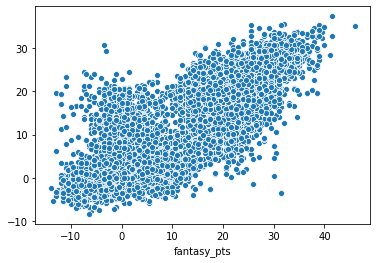

In [ ]:
# Random forest regressor analysis
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))
print("Test MAE:", mean_absolute_error(y_pred, y_test))
sns.scatterplot(x = y_test, y = y_pred)